In [1]:
from importlib.resources import files
instance_one_day_path = files('evrp.data.instances').joinpath('instance_2023-04-04.csv')
unique_locations_path = files('evrp.data').joinpath('unique_locations.csv')
bookings_mapping_path = files('evrp.data').joinpath('bookings_mapping.csv')
stations_mapping_path = files('evrp.data').joinpath('stations_mapping.csv')
distance_matrix_path = files('evrp.data').joinpath('distance_matrix.json')
duration_matrix_path = files('evrp.data').joinpath('duration_matrix.json')

## PDP (Showcasing how the model class works)

In [2]:
from evrp.util.instance_loader import load_instance
from evrp.config.config import SolverConfig, PDPConfig
from evrp.solver.pdp import PDPSolver
config = PDPConfig()

data = load_instance(config=config,
                     problem_path=instance_one_day_path,unique_locations_path=unique_locations_path,    distance_matrix_path=distance_matrix_path,time_matrix_path=duration_matrix_path,)

# solver = PDPSolver(data=data)
# solver.create_model()

/Users/sy/Documents/GitHub/electric-vehicle-pickup-and-delivery/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading instance from: /Users/sy/Documents/GitHub/electric-vehicle-pickup-and-delivery/evrp/data/instances/instance_2023-04-04.csv


In [6]:
# Define the strategies and metaheuristics
first_solution_strategies = [
    'PATH_CHEAPEST_ARC', 'PATH_MOST_CONSTRAINED_ARC','SAVINGS',
    'ALL_UNPERFORMED', 'BEST_INSERTION',
    'PARALLEL_CHEAPEST_INSERTION', 'LOCAL_CHEAPEST_INSERTION',
    'GLOBAL_CHEAPEST_ARC', 'LOCAL_CHEAPEST_ARC','FIRST_UNBOUND_MIN_VALUE'
]
local_search_metaheuristics = [
    'GREEDY_DESCENT', 'GUIDED_LOCAL_SEARCH',
    'SIMULATED_ANNEALING', 'TABU_SEARCH', 'GENERIC_TABU_SEARCH'
]

In [7]:
# Prepare a dictionary to store convergence data
convergence_data_pdp = {}

# Iterate over all combinations of first_solution_strategies and local_search_metaheuristics
for first_solution in first_solution_strategies:
    convergence_data_pdp[first_solution] = {}
    for local_search in local_search_metaheuristics:
        try:
            # Reinitialize the solver instance and model for each combination
            solver = PDPSolver(data=data)
            solver.create_model()

            # Create and configure the SolverConfig instance
            solver_settings = SolverConfig(
                first_solution_strategy=first_solution,
                local_search_metaheuristic=local_search,
                time_limit=50
            )

            # Solve the model with the current settings
            solver.solve_model(settings=solver_settings, log_search=False)
            solver.get_solution_data()
            print(f'{first_solution} x {local_search} finished')

            # Collect convergence data from the solution log
            times = []
            objective_values = []
            for log in solver.solution_log.values():
                times.append(log['time'])
                objective_values.append(log['min_objective_value'])

            convergence_data_pdp[first_solution][local_search] = (times, objective_values)
        
        except Exception as e:
            # Print the error message and continue with the next combination
            print(f'Error for {first_solution} x {local_search}: {e}')
            continue



Solving without initial
Solution found
PATH_CHEAPEST_ARC x GREEDY_DESCENT finished
Solving without initial
Solution found
PATH_CHEAPEST_ARC x GUIDED_LOCAL_SEARCH finished
Solving without initial
Solution found
PATH_CHEAPEST_ARC x SIMULATED_ANNEALING finished
Solving without initial
Solution found
PATH_CHEAPEST_ARC x TABU_SEARCH finished
Solving without initial
Solution found
PATH_CHEAPEST_ARC x GENERIC_TABU_SEARCH finished
Solving without initial
Solution found
PATH_MOST_CONSTRAINED_ARC x GREEDY_DESCENT finished
Solving without initial
Solution found
PATH_MOST_CONSTRAINED_ARC x GUIDED_LOCAL_SEARCH finished
Solving without initial
Solution found
PATH_MOST_CONSTRAINED_ARC x SIMULATED_ANNEALING finished
Solving without initial
Solution found
PATH_MOST_CONSTRAINED_ARC x TABU_SEARCH finished
Solving without initial
Solution found
PATH_MOST_CONSTRAINED_ARC x GENERIC_TABU_SEARCH finished
Solving without initial
Solution Not Found
Solution not existing
Error for SAVINGS x GREEDY_DESCENT: 'None

In [ ]:
# solver.save_solution('test.json')

In [8]:
import json
output_file = '../solutions/convergence_data_0404_pdp.json'
with open(output_file, 'w') as json_file:
    json.dump(convergence_data_pdp, json_file, indent=4)

print(f"Convergence data saved to {output_file}")

Convergence data saved to ../solutions/convergence_data_0404_pdp.json


In [9]:
# Initialize a list to store strategies with empty convergence data
empty_strategies = []

# Iterate over the convergence data to find empty lists
for initial_solution, metaheuristics in convergence_data_pdp.items():
    for metaheuristic, (times, objective_values) in metaheuristics.items():
        if not times or not objective_values:  # Check if either list is empty
            empty_strategies.append((initial_solution, metaheuristic))

# Print out the strategies with empty convergence data
if empty_strategies:
    print("Strategies with empty convergence data:")
    for initial_solution, metaheuristic in empty_strategies:
        print(f'{initial_solution} x {metaheuristic}')
else:
    print("No strategies with empty convergence data found.")
    
# Remove strategies with empty convergence data
for initial_solution, metaheuristic in empty_strategies:
    del convergence_data_pdp[initial_solution][metaheuristic]
    # If the initial solution has no more metaheuristics, remove it as well
    if not convergence_data_pdp[initial_solution]:
        del convergence_data_pdp[initial_solution]


No strategies with empty convergence data found.


In [10]:
def get_final_objective_values(convergence_data):
    final_objective_values = {}

    for initial_solution, local_search_data in convergence_data.items():
        for local_search_method, (times, objective_values) in local_search_data.items():
            if objective_values:  # Ensure the list is not empty
                final_objective = min(objective_values)
                if initial_solution not in final_objective_values:
                    final_objective_values[initial_solution] = {}
                final_objective_values[initial_solution][local_search_method] = final_objective

    return final_objective_values

# Example usage:
final_objective_values = get_final_objective_values(convergence_data_pdp)
for initial_solution, local_search_data in final_objective_values.items():
    for local_search_method, final_objective in local_search_data.items():
        print(f"Final objective value for {initial_solution} x {local_search_method}: {final_objective}")


Final objective value for PATH_CHEAPEST_ARC x GREEDY_DESCENT: 186
Final objective value for PATH_CHEAPEST_ARC x GUIDED_LOCAL_SEARCH: 186
Final objective value for PATH_CHEAPEST_ARC x SIMULATED_ANNEALING: 186
Final objective value for PATH_CHEAPEST_ARC x TABU_SEARCH: 186
Final objective value for PATH_CHEAPEST_ARC x GENERIC_TABU_SEARCH: 186
Final objective value for PATH_MOST_CONSTRAINED_ARC x GREEDY_DESCENT: 188
Final objective value for PATH_MOST_CONSTRAINED_ARC x GUIDED_LOCAL_SEARCH: 186
Final objective value for PATH_MOST_CONSTRAINED_ARC x SIMULATED_ANNEALING: 188
Final objective value for PATH_MOST_CONSTRAINED_ARC x TABU_SEARCH: 186
Final objective value for PATH_MOST_CONSTRAINED_ARC x GENERIC_TABU_SEARCH: 188
Final objective value for PARALLEL_CHEAPEST_INSERTION x GREEDY_DESCENT: 192
Final objective value for PARALLEL_CHEAPEST_INSERTION x GUIDED_LOCAL_SEARCH: 188
Final objective value for PARALLEL_CHEAPEST_INSERTION x SIMULATED_ANNEALING: 192
Final objective value for PARALLEL_CHE

In [11]:
# Initialize a variable to store the lowest objective value found
best_objective_value = float('inf')

# Iterate over the convergence data to find the lowest objective value
for initial_solution, metaheuristics in convergence_data_pdp.items():
    for metaheuristic, (times, objective_values) in metaheuristics.items():
        if objective_values:  # Check if the list is not empty
            min_value = min(objective_values)
            if min_value < best_objective_value:
                best_objective_value = min_value

print(f'The best known objective value found is: {best_objective_value}')


The best known objective value found is: 186


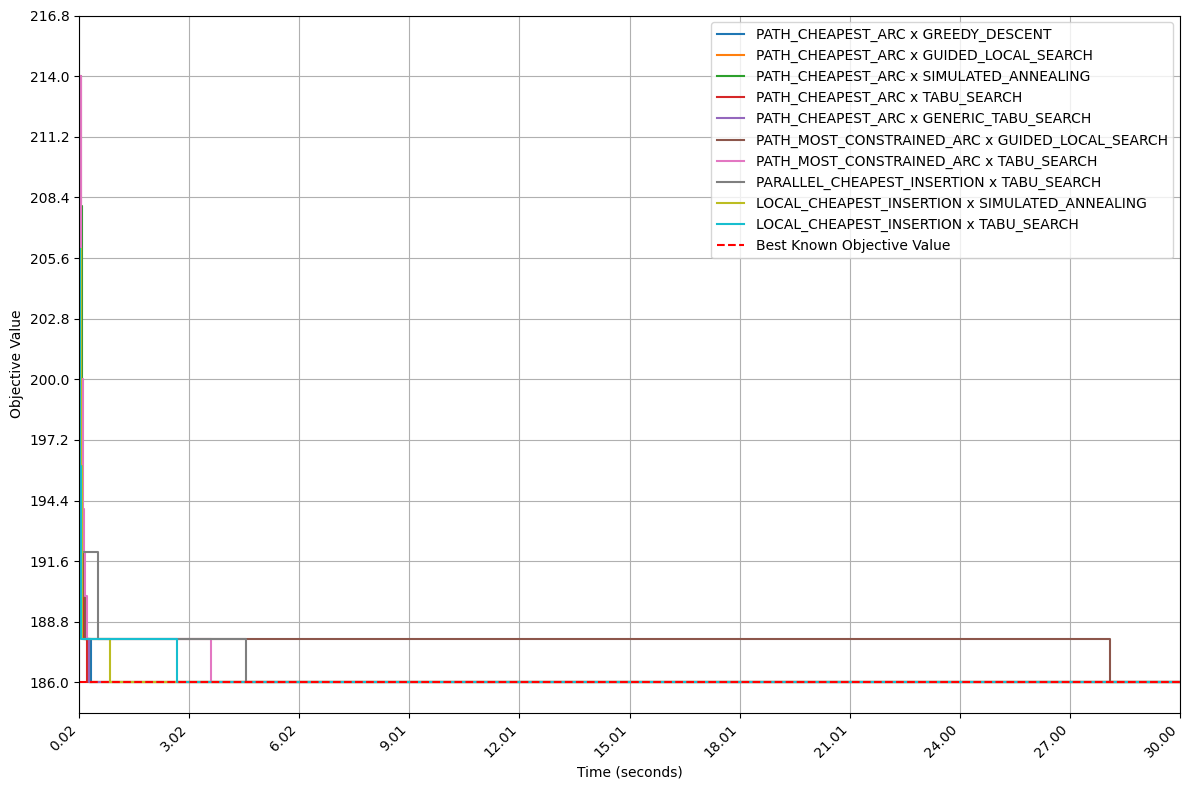

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# For selected combination 
def plot_convergence(combinations, convergence_data, best_objective_value):
    plt.figure(figsize=(12, 8))
    
    for initial_solution, local_search_method in combinations:
        if initial_solution not in convergence_data:
            print(f"Initial solution '{initial_solution}' not found in convergence data.")
            continue

        if local_search_method not in convergence_data[initial_solution]:
            print(f"Local search method '{local_search_method}' not found for initial solution '{initial_solution}'.")
            continue

        times, objective_values = convergence_data[initial_solution][local_search_method]

        if not times or not objective_values:
            print(f"No data available for initial solution '{initial_solution}' and local search method '{local_search_method}'.")
            continue

        # Convert times from milliseconds to seconds
        times_seconds = [t / 1000 for t in times]

        # Use step plot to create constant value for each time interval
        plt.step(times_seconds, objective_values, where='post', label=f'{initial_solution} x {local_search_method}')

    # Plot the best known objective value as a baseline
    plt.axhline(y=best_objective_value, color='r', linestyle='--', label='Best Known Objective Value')

    # Set x-axis and y-axis labels
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.grid(True)

    # Set x-axis ticks to regular intervals
    num_xticks = 10  # Set number of x-ticks you prefer
    max_time = 30
    min_time = min([min(t / 1000 for t in times) for times, _ in [convergence_data[initial_solution][local_search_method] for initial_solution, local_search_method in combinations]])
    x_tick_interval = (max_time - min_time) / num_xticks
    x_tick_values = np.arange(min_time, max_time + x_tick_interval, x_tick_interval)

    plt.xticks(x_tick_values, rotation=45, ha='right')

    # Set y-axis ticks to regular intervals
    num_yticks = 10  # Set number of y-ticks you prefer
    max_value = max([max(objective_values) for _, objective_values in [convergence_data[initial_solution][local_search_method] for initial_solution, local_search_method in combinations]])
    min_value = best_objective_value
    
    y_tick_interval = (max_value - min_value) / num_yticks
    y_tick_values = np.arange(min_value, max_value + y_tick_interval, y_tick_interval)

    plt.yticks(y_tick_values)
    
    # Set y-axis limits with a buffer below the best known objective value
    buffer = 0.05 * (max_value - best_objective_value)  # 5% buffer
    plt.ylim(bottom=best_objective_value - buffer, top=max_value + y_tick_interval)
    plt.xlim([min_time, max_time])

    plt.tight_layout()
    plt.show()

# Example usage:
combinations = [
    ('PATH_CHEAPEST_ARC', 'GREEDY_DESCENT'),
    ('PATH_CHEAPEST_ARC', 'GUIDED_LOCAL_SEARCH'),
    ('PATH_CHEAPEST_ARC', 'SIMULATED_ANNEALING'),
    ('PATH_CHEAPEST_ARC', 'TABU_SEARCH'),
    ('PATH_CHEAPEST_ARC', 'GENERIC_TABU_SEARCH'),
    ('PATH_MOST_CONSTRAINED_ARC', 'GUIDED_LOCAL_SEARCH'),
    ('PATH_MOST_CONSTRAINED_ARC', 'TABU_SEARCH'),
    ('PARALLEL_CHEAPEST_INSERTION', 'TABU_SEARCH'),
    ('LOCAL_CHEAPEST_INSERTION', 'SIMULATED_ANNEALING'),
    ('LOCAL_CHEAPEST_INSERTION', 'TABU_SEARCH'),
]

plot_convergence(combinations, convergence_data_pdp, best_objective_value)


## EPDP

In [4]:
from importlib.resources import files
instance_one_day_path = files('evrp.data.instances').joinpath('instance_2023-04-04.csv')
unique_locations_path = files('evrp.data').joinpath('unique_locations.csv')
bookings_mapping_path = files('evrp.data').joinpath('bookings_mapping.csv')
stations_mapping_path = files('evrp.data').joinpath('stations_mapping.csv')
distance_matrix_path = files('evrp.data').joinpath('distance_matrix.json')
duration_matrix_path = files('evrp.data').joinpath('duration_matrix.json')

In [5]:
from evrp.util.instance_loader import load_instance
from evrp.config.config import SolverConfig, EPDPConfig
from evrp.solver.epdp import EPDPSolver
config = EPDPConfig()

data = load_instance(config=config,
                     problem_path=instance_one_day_path,
                     unique_locations_path=unique_locations_path,
                     distance_matrix_path=distance_matrix_path,
                     time_matrix_path=duration_matrix_path,
                     charging_stations_path=stations_mapping_path
                     )

solver = EPDPSolver(data=data)
solver.create_model()

/Users/sy/Documents/GitHub/electric-vehicle-pickup-and-delivery/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading instance from: /Users/sy/Documents/GitHub/electric-vehicle-pickup-and-delivery/evrp/data/instances/instance_2023-04-04.csv


### Results

#### Combinations of all first solution strategies and metaheurstics

In [9]:
# Define the strategies and metaheuristics
first_solution_strategies = [
    'PATH_CHEAPEST_ARC', 'PATH_MOST_CONSTRAINED_ARC',
    'SAVINGS', 'ALL_UNPERFORMED', 'BEST_INSERTION',
    'PARALLEL_CHEAPEST_INSERTION', 'LOCAL_CHEAPEST_INSERTION',
    'GLOBAL_CHEAPEST_ARC', 'LOCAL_CHEAPEST_ARC'
]
local_search_metaheuristics = [
    'GREEDY_DESCENT', 'GUIDED_LOCAL_SEARCH',
    'SIMULATED_ANNEALING', 'TABU_SEARCH', 'GENERIC_TABU_SEARCH'
]

In [ ]:
import itertools

# Prepare a list to store results
results = []

# Iterate over all combinations of strategies and metaheuristics
for first_solution, local_search in itertools.product(first_solution_strategies, local_search_metaheuristics):
    solver = EPDPSolver(data=data)
    solver.create_model()
    
    # Create and configure the SolverConfig instance
    solver_settings = SolverConfig(
        first_solution_strategy=first_solution,
        local_search_metaheuristic=local_search,
        time_limit=200
    )

    # Solve the model with the current settings
    solver.solve_model(settings=solver_settings, log_search=False)
    solver.get_solution_data()
    
    # Find the time it took to achieve the final objective value for the first time
    final_objective_value = solver.solution.ObjectiveValue()
    time_to_objective = None
    for log in solver.solution_log.values():
        if log['objective_value'] == final_objective_value:
            time_to_objective = log['time']
            break

    # Store the result
    result = {
        'first_solution_strategy': first_solution,
        'local_search_metaheuristic': local_search,
        'objective_value': final_objective_value,
        'time_to_objective': time_to_objective
    }
    results.append(result)


In [ ]:
# Print the results for analysis
for result in results:
    print(result)

#### Convergence analysis (fixed first solution strategy vs convergence of different metaheuristics)

In [10]:
# Prepare a dictionary to store convergence data
convergence_data = {}

# Iterate over all combinations of first_solution_strategies and local_search_metaheuristics
for first_solution in first_solution_strategies:
    convergence_data[first_solution] = {}
    for local_search in local_search_metaheuristics:
        # Reinitialize the solver instance and model for each combination
        solver = EPDPSolver(data=data)
        solver.create_model()

        # Create and configure the SolverConfig instance
        solver_settings = SolverConfig(
            first_solution_strategy=first_solution,
            local_search_metaheuristic=local_search,
            time_limit=200
        )

        # Solve the model with the current settings
        solver.solve_model(settings=solver_settings, log_search=False)
        solver.get_solution_data()
        print(f'{first_solution} x {local_search} finished')

        # Collect convergence data from the solution log
        times = []
        objective_values = []
        for log in solver.solution_log.values():
            times.append(log['time'])
            objective_values.append(log['min_objective_value'])

        convergence_data[first_solution][local_search] = (times, objective_values)

Solving without initial
PATH_CHEAPEST_ARC x GREEDY_DESCENT finished
Solving without initial
PATH_CHEAPEST_ARC x GUIDED_LOCAL_SEARCH finished
Solving without initial
PATH_CHEAPEST_ARC x SIMULATED_ANNEALING finished
Solving without initial
PATH_CHEAPEST_ARC x TABU_SEARCH finished
Solving without initial
PATH_CHEAPEST_ARC x GENERIC_TABU_SEARCH finished
Solving without initial
PATH_MOST_CONSTRAINED_ARC x GREEDY_DESCENT finished
Solving without initial
PATH_MOST_CONSTRAINED_ARC x GUIDED_LOCAL_SEARCH finished
Solving without initial
PATH_MOST_CONSTRAINED_ARC x SIMULATED_ANNEALING finished
Solving without initial
PATH_MOST_CONSTRAINED_ARC x TABU_SEARCH finished
Solving without initial
PATH_MOST_CONSTRAINED_ARC x GENERIC_TABU_SEARCH finished
Solving without initial
SAVINGS x GREEDY_DESCENT finished
Solving without initial
SAVINGS x GUIDED_LOCAL_SEARCH finished
Solving without initial
SAVINGS x SIMULATED_ANNEALING finished
Solving without initial
SAVINGS x TABU_SEARCH finished
Solving without i

In [11]:
import json
output_file = '../solutions/convergence_data_0404.json'
with open(output_file, 'w') as json_file:
    json.dump(convergence_data, json_file, indent=4)

print(f"Convergence data saved to {output_file}")

Convergence data saved to ../solutions/convergence_data_0404.json


In [36]:
# Initialize a variable to store the lowest objective value found
best_objective_value = float('inf')

# Iterate over the convergence data to find the lowest objective value
for initial_solution, metaheuristics in convergence_data.items():
    for metaheuristic, (times, objective_values) in metaheuristics.items():
        if objective_values:  # Check if the list is not empty
            min_value = min(objective_values)
            if min_value < best_objective_value:
                best_objective_value = min_value

print(f'The best known objective value found is: {best_objective_value}')


The best known objective value found is: 438


In [ ]:
# Initialize a list to store strategies with empty convergence data
empty_strategies = []

# Iterate over the convergence data to find empty lists
for initial_solution, metaheuristics in convergence_data.items():
    for metaheuristic, (times, objective_values) in metaheuristics.items():
        if not times or not objective_values:  # Check if either list is empty
            empty_strategies.append((initial_solution, metaheuristic))

# Print out the strategies with empty convergence data
if empty_strategies:
    print("Strategies with empty convergence data:")
    for initial_solution, metaheuristic in empty_strategies:
        print(f'{initial_solution} x {metaheuristic}')
else:
    print("No strategies with empty convergence data found.")
    
# Remove strategies with empty convergence data
for initial_solution, metaheuristic in empty_strategies:
    del convergence_data[initial_solution][metaheuristic]
    # If the initial solution has no more metaheuristics, remove it as well
    if not convergence_data[initial_solution]:
        del convergence_data[initial_solution]


In [59]:
def get_final_objective_values(convergence_data):
    final_objective_values = {}

    for initial_solution, local_search_data in convergence_data.items():
        for local_search_method, (times, objective_values) in local_search_data.items():
            if objective_values:  # Ensure the list is not empty
                final_objective = min(objective_values)
                if initial_solution not in final_objective_values:
                    final_objective_values[initial_solution] = {}
                final_objective_values[initial_solution][local_search_method] = final_objective

    return final_objective_values

# Example usage:
final_objective_values = get_final_objective_values(convergence_data)
for initial_solution, local_search_data in final_objective_values.items():
    for local_search_method, final_objective in local_search_data.items():
        print(f"Final objective value for {initial_solution} x {local_search_method}: {final_objective}")


Final objective value for PATH_CHEAPEST_ARC x GREEDY_DESCENT: 784
Final objective value for PATH_CHEAPEST_ARC x GUIDED_LOCAL_SEARCH: 702
Final objective value for PATH_CHEAPEST_ARC x SIMULATED_ANNEALING: 784
Final objective value for PATH_CHEAPEST_ARC x TABU_SEARCH: 560
Final objective value for PATH_CHEAPEST_ARC x GENERIC_TABU_SEARCH: 742
Final objective value for PATH_MOST_CONSTRAINED_ARC x GREEDY_DESCENT: 786
Final objective value for PATH_MOST_CONSTRAINED_ARC x GUIDED_LOCAL_SEARCH: 742
Final objective value for PATH_MOST_CONSTRAINED_ARC x SIMULATED_ANNEALING: 742
Final objective value for PATH_MOST_CONSTRAINED_ARC x TABU_SEARCH: 438
Final objective value for PATH_MOST_CONSTRAINED_ARC x GENERIC_TABU_SEARCH: 748
Final objective value for SAVINGS x GREEDY_DESCENT: 596
Final objective value for SAVINGS x GUIDED_LOCAL_SEARCH: 510
Final objective value for SAVINGS x SIMULATED_ANNEALING: 596
Final objective value for SAVINGS x TABU_SEARCH: 438
Final objective value for SAVINGS x GENERIC_T

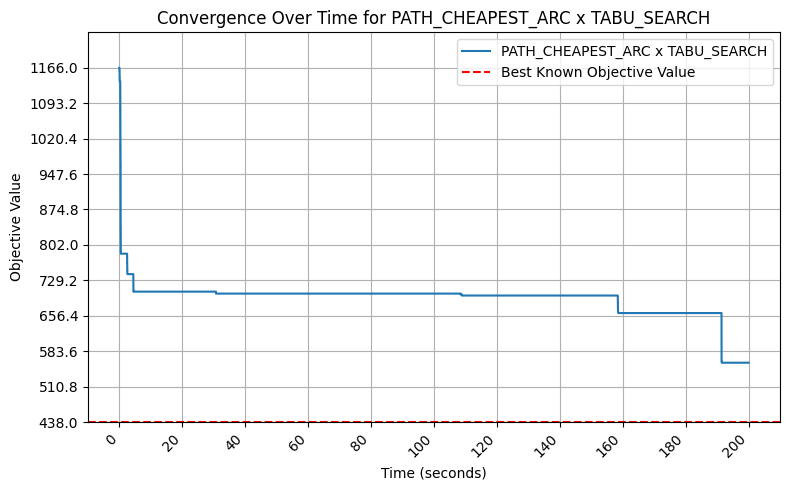

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence(initial_solution, local_search_method, convergence_data, best_objective_value):
    if initial_solution not in convergence_data:
        print(f"Initial solution '{initial_solution}' not found in convergence data.")
        return
    
    if local_search_method not in convergence_data[initial_solution]:
        print(f"Local search method '{local_search_method}' not found for initial solution '{initial_solution}'.")
        return
    
    times, objective_values = convergence_data[initial_solution][local_search_method]
    
    if not times or not objective_values:
        print(f"No data available for initial solution '{initial_solution}' and local search method '{local_search_method}'.")
        return
    
    # Convert times from milliseconds to minutes
    times_seconds = [t / 1000 for t in times]
    
    # Create a plot
    plt.figure(figsize=(8, 5))
    
    # Use step plot to create constant value for each time interval
    plt.step(times_seconds, objective_values, where='post', label=f'{initial_solution} x {local_search_method}')
    
    # Plot the best known objective value as a baseline
    plt.axhline(y=best_objective_value, color='r', linestyle='--', label='Best Known Objective Value')
    
    # Set x-axis and y-axis labels
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.title(f'Convergence Over Time for {initial_solution} x {local_search_method}')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis ticks to regular intervals
    num_xticks = 10  # Set number of x-ticks you prefer
    max_time = max(times_seconds)
    min_time = min(times_seconds)
    x_tick_interval = (max_time - min_time) / num_xticks
    x_tick_values = np.arange(min_time, max_time + x_tick_interval, x_tick_interval)
    
    plt.xticks(x_tick_values, rotation=45, ha='right')
    
    # Set y-axis ticks to regular intervals
    num_yticks = 10  # Set number of y-ticks you prefer
    max_value = max(objective_values)
    min_value = best_objective_value
    y_tick_interval = (max_value - min_value) / num_yticks
    y_tick_values = np.arange(min_value, max_value + y_tick_interval, y_tick_interval)
    
    plt.yticks(y_tick_values)
    # Set y-axis limits
    plt.ylim(bottom=best_objective_value, top=max_value + y_tick_interval)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_convergence('PATH_CHEAPEST_ARC', 'TABU_SEARCH', convergence_data, best_objective_value)


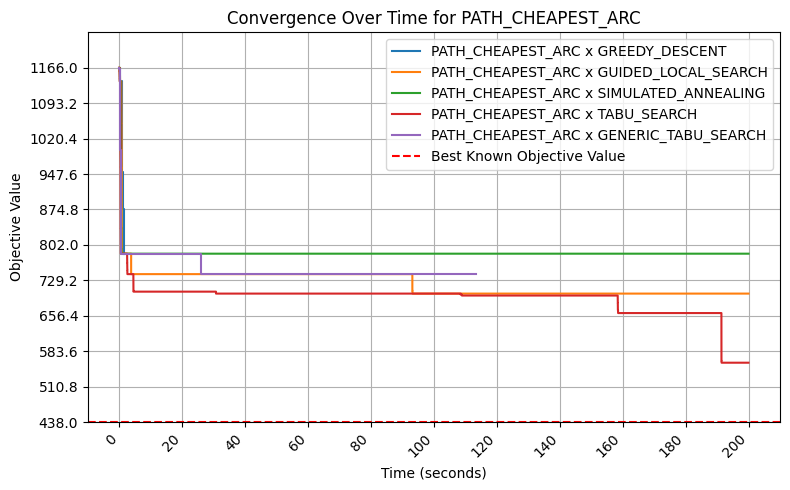

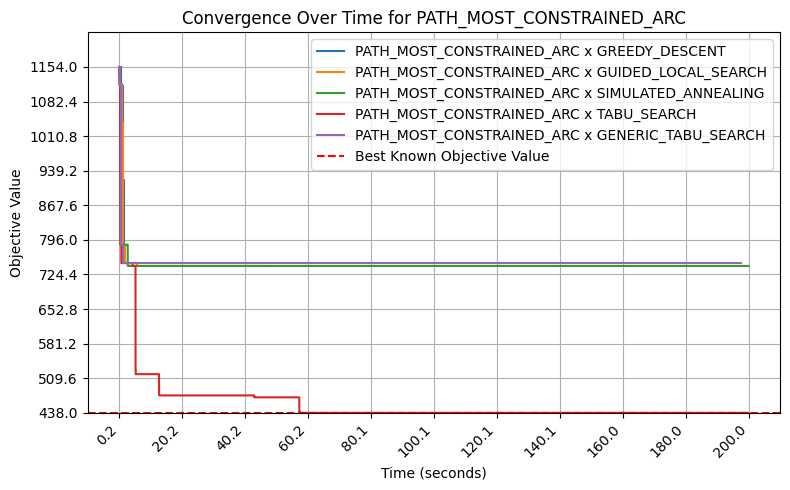

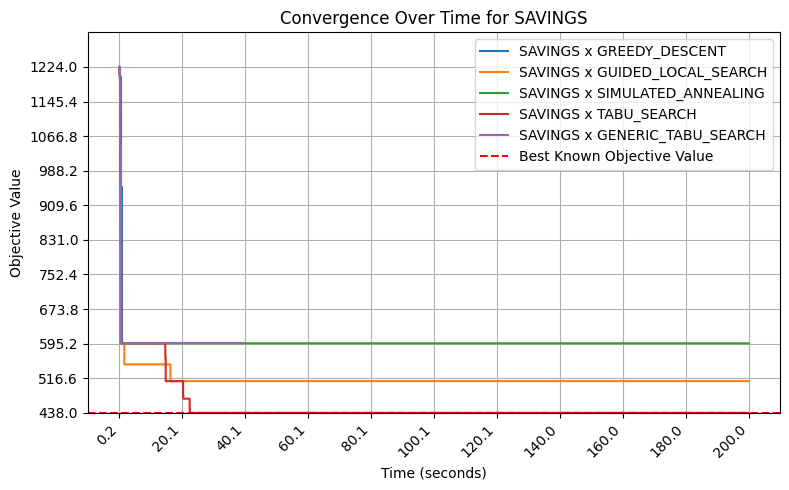

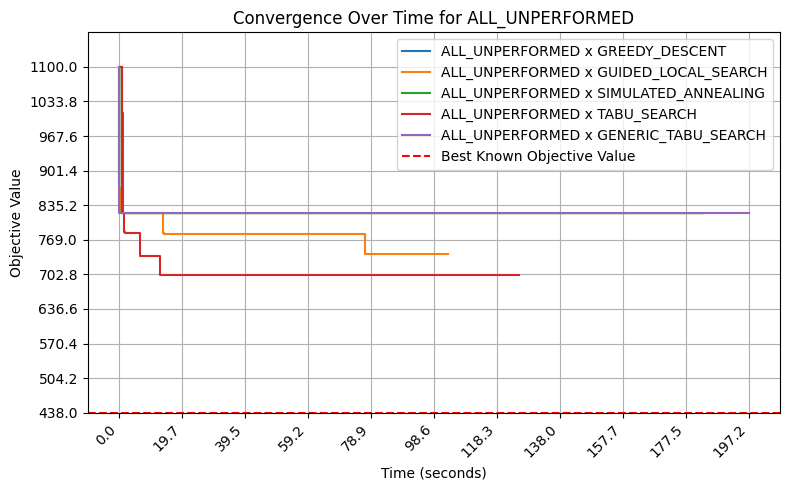

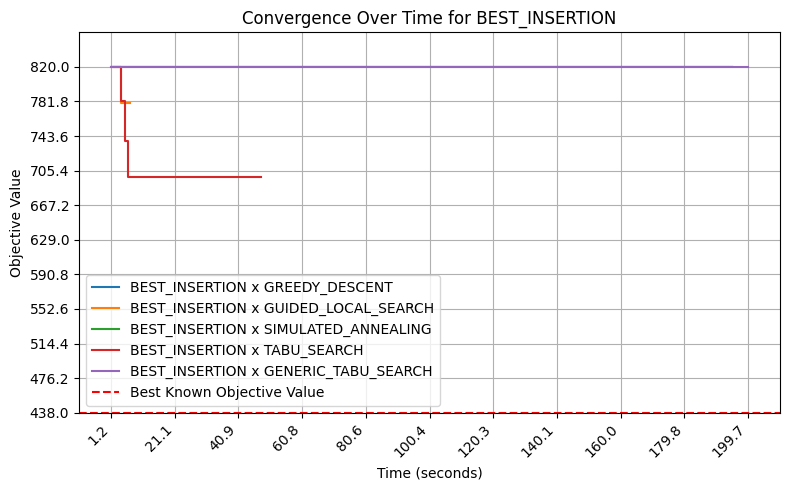

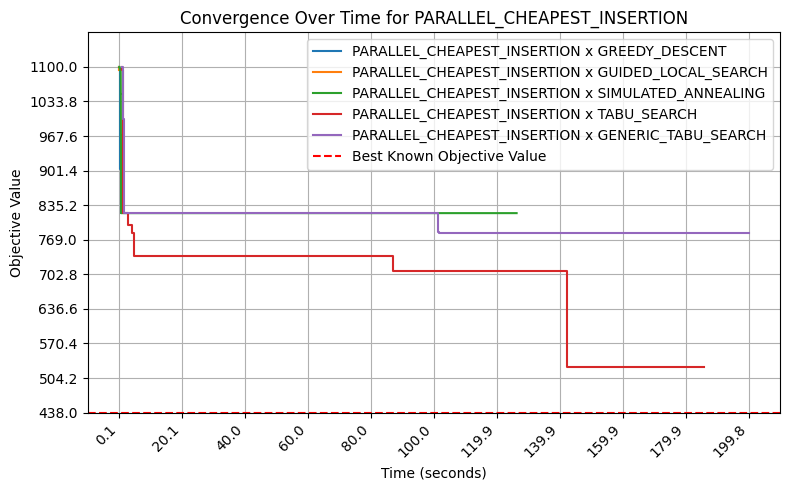

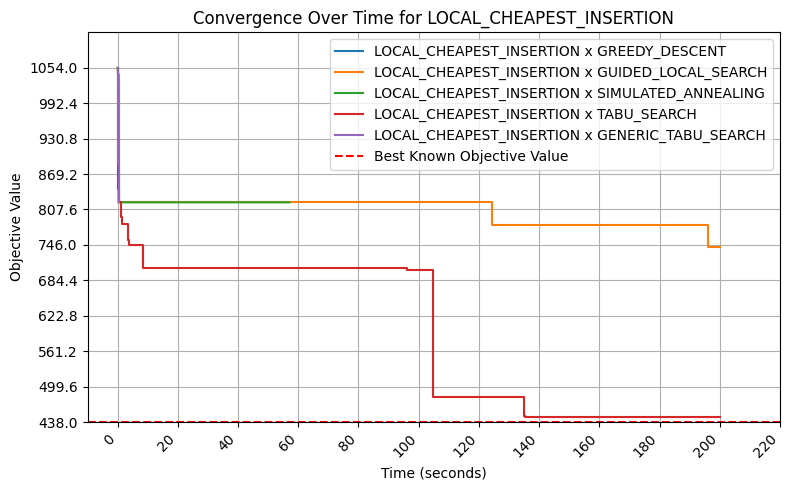

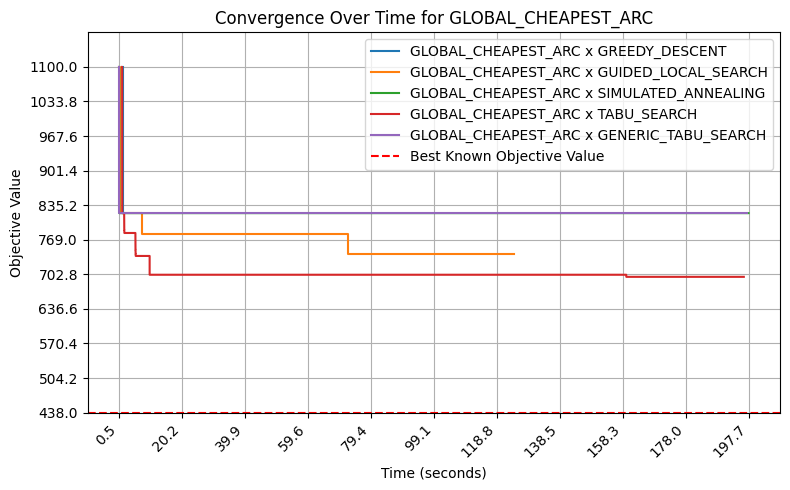

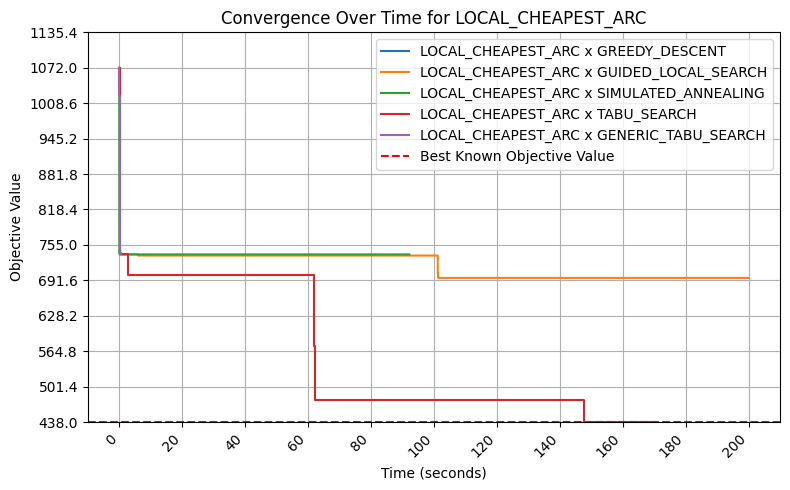

In [61]:
# For each initial soltuion, all combination

def plot_convergence_for_initial_solution(initial_solution, convergence_data, best_objective_value):
    if initial_solution not in convergence_data:
        print(f"Initial solution '{initial_solution}' not found in convergence data.")
        return
    
    plt.figure(figsize=(8, 5))
    
    for local_search_method in convergence_data[initial_solution]:
        times, objective_values = convergence_data[initial_solution][local_search_method]

        if not times or not objective_values:
            print(f"No data available for initial solution '{initial_solution}' and local search method '{local_search_method}'.")
            continue

        # Convert times from milliseconds to seconds
        times_seconds = [t / 1000 for t in times]

        # Use step plot to create constant value for each time interval
        plt.step(times_seconds, objective_values, where='post', label=f'{initial_solution} x {local_search_method}')

    # Plot the best known objective value as a baseline
    plt.axhline(y=best_objective_value, color='r', linestyle='--', label='Best Known Objective Value')

    # Set x-axis and y-axis labels
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.title(f'Convergence Over Time for {initial_solution}')
    plt.legend()
    plt.grid(True)

    # Set x-axis ticks to regular intervals
    num_xticks = 10  # Set number of x-ticks you prefer
    max_time = max([max(t / 1000 for t in times) for times, _ in convergence_data[initial_solution].values()])
    min_time = min([min(t / 1000 for t in times) for times, _ in convergence_data[initial_solution].values()])
    x_tick_interval = (max_time - min_time) / num_xticks
    x_tick_values = np.arange(min_time, max_time + x_tick_interval, x_tick_interval)

    plt.xticks(x_tick_values, rotation=45, ha='right')

    # Set y-axis ticks to regular intervals
    num_yticks = 10  # Set number of y-ticks you prefer
    max_value = max([max(objective_values) for _, objective_values in convergence_data[initial_solution].values()])
    min_value = best_objective_value
    y_tick_interval = (max_value - min_value) / num_yticks
    y_tick_values = np.arange(min_value, max_value + y_tick_interval, y_tick_interval)

    plt.yticks(y_tick_values)
    # Set y-axis limits
    plt.ylim(bottom=best_objective_value, top=max_value + y_tick_interval)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_convergence_for_initial_solution('PATH_CHEAPEST_ARC', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('PATH_MOST_CONSTRAINED_ARC', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('SAVINGS', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('ALL_UNPERFORMED', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('BEST_INSERTION', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('PARALLEL_CHEAPEST_INSERTION', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('LOCAL_CHEAPEST_INSERTION', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('GLOBAL_CHEAPEST_ARC', convergence_data, best_objective_value)
plot_convergence_for_initial_solution('LOCAL_CHEAPEST_ARC', convergence_data, best_objective_value)


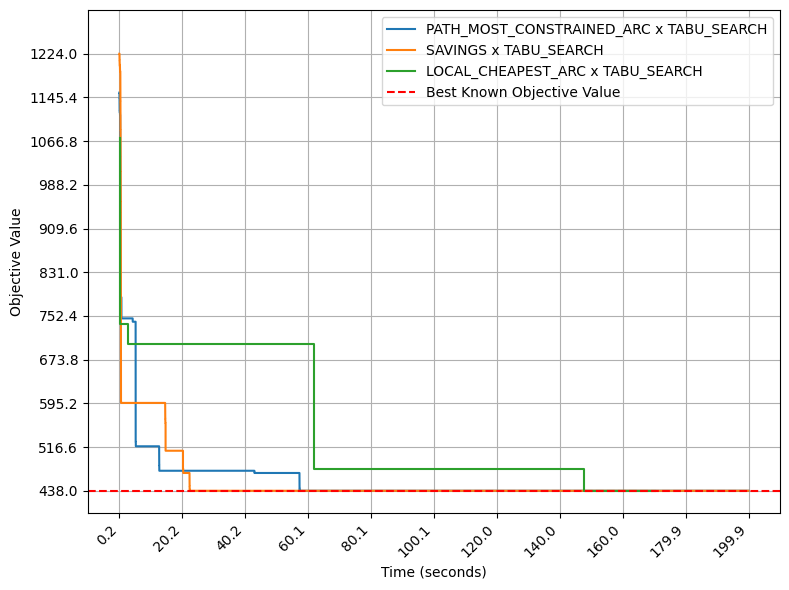

In [60]:
import matplotlib.pyplot as plt
import numpy as np
# for selected Combination 
def plot_convergence(combinations, convergence_data, best_objective_value):
    plt.figure(figsize=(8, 6))
    
    for initial_solution, local_search_method in combinations:
        if initial_solution not in convergence_data:
            print(f"Initial solution '{initial_solution}' not found in convergence data.")
            continue

        if local_search_method not in convergence_data[initial_solution]:
            print(f"Local search method '{local_search_method}' not found for initial solution '{initial_solution}'.")
            continue

        times, objective_values = convergence_data[initial_solution][local_search_method]

        if not times or not objective_values:
            print(f"No data available for initial solution '{initial_solution}' and local search method '{local_search_method}'.")
            continue

        # Convert times from milliseconds to seconds
        times_seconds = [t / 1000 for t in times]

        # Use step plot to create constant value for each time interval
        plt.step(times_seconds, objective_values, where='post', label=f'{initial_solution} x {local_search_method}')

    # Plot the best known objective value as a baseline
    plt.axhline(y=best_objective_value, color='r', linestyle='--', label='Best Known Objective Value')

    # Set x-axis and y-axis labels
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.grid(True)

    # Set x-axis ticks to regular intervals
    num_xticks = 10  # Set number of x-ticks you prefer
    max_time = max([max(t / 1000 for t in times) for times, _ in [convergence_data[initial_solution][local_search_method] for initial_solution, local_search_method in combinations]])
    min_time = min([min(t / 1000 for t in times) for times, _ in [convergence_data[initial_solution][local_search_method] for initial_solution, local_search_method in combinations]])
    x_tick_interval = (max_time - min_time) / num_xticks
    x_tick_values = np.arange(min_time, max_time + x_tick_interval, x_tick_interval)

    plt.xticks(x_tick_values, rotation=45, ha='right')

    # Set y-axis ticks to regular intervals
    num_yticks = 10  # Set number of y-ticks you prefer
    max_value = max([max(objective_values) for _, objective_values in [convergence_data[initial_solution][local_search_method] for initial_solution, local_search_method in combinations]])
    min_value = best_objective_value
    y_tick_interval = (max_value - min_value) / num_yticks
    y_tick_values = np.arange(min_value, max_value + y_tick_interval, y_tick_interval)

    plt.yticks(y_tick_values)
    # Set y-axis limits with a buffer below the best known objective value
    buffer = 0.05 * (max_value - best_objective_value)  # 5% buffer
    plt.ylim(bottom=best_objective_value - buffer, top=max_value + y_tick_interval)

    plt.tight_layout()
    plt.show()

# Example usage:
combinations = [
    ('PATH_MOST_CONSTRAINED_ARC', 'TABU_SEARCH'),
    ('SAVINGS', 'TABU_SEARCH'),
    ('LOCAL_CHEAPEST_ARC', 'TABU_SEARCH')
]

plot_convergence(combinations, convergence_data, best_objective_value)


In [ ]:
# for all combination
import matplotlib.pyplot as plt

# Create a single plot
plt.figure(figsize=(12, 8))
try:
    # Iterate over each first solution strategy and its respective local search strategies
    for first_solution in first_solution_strategies:
        for local_search, (times, objective_values) in convergence_data[first_solution].items():
            if times and objective_values:  # Check if lists are not empty
                # Create a label combining the first solution and local search strategy
                label = f'{first_solution} x {local_search}'
                plt.plot(times, objective_values, label=label)
except KeyError:
        print('Keyerror')
except Exception as e:
    print(f"Unexpected error: {e}. Skipping...")

# Plot the best known objective value as a baseline
plt.axhline(y=best_objective_value, color='r', linestyle='--', label='Best Known Objective Value')

plt.xlabel('Time (ms)')
plt.ylabel('Objective Value')
plt.title('Convergence Over Time for Different Strategies')
plt.legend()
plt.grid(True)
plt.show()

# Min vs OBjective 

In [6]:
import json
with open('../solutions/epdp/solution_epdp_2023-04-21.json', 'r') as f:
    initial_solution = json.load(f)

In [7]:
solution_log = initial_solution['solution_log']
solution_log

{'0': {'objective_value': 1850, 'min_objective_value': 1850, 'time': 123},
 '1': {'objective_value': 1846, 'min_objective_value': 1846, 'time': 143},
 '2': {'objective_value': 1844, 'min_objective_value': 1844, 'time': 146},
 '3': {'objective_value': 1842, 'min_objective_value': 1842, 'time': 162},
 '4': {'objective_value': 1840, 'min_objective_value': 1840, 'time': 167},
 '5': {'objective_value': 1838, 'min_objective_value': 1838, 'time': 186},
 '6': {'objective_value': 1836, 'min_objective_value': 1836, 'time': 219},
 '7': {'objective_value': 1832, 'min_objective_value': 1832, 'time': 246},
 '8': {'objective_value': 1830, 'min_objective_value': 1830, 'time': 293},
 '9': {'objective_value': 1828, 'min_objective_value': 1828, 'time': 318},
 '10': {'objective_value': 1824, 'min_objective_value': 1824, 'time': 321},
 '11': {'objective_value': 1821, 'min_objective_value': 1821, 'time': 324},
 '12': {'objective_value': 1819, 'min_objective_value': 1819, 'time': 327},
 '13': {'objective_val

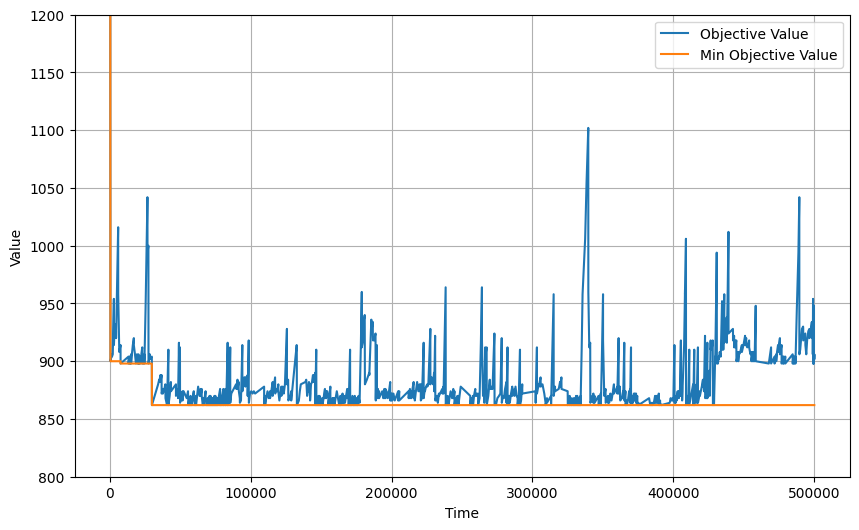

In [11]:
import matplotlib.pyplot as plt
# Extracting the time, objective_value, and min_objective_value from the data
times = []
objective_values = []
min_objective_values = []

for key in solution_log:
    entry = solution_log[key]
    if "time" in entry:
        times.append(entry["time"])
        objective_values.append(entry["objective_value"])
        min_objective_values.append(entry["min_objective_value"])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(times, objective_values, label='Objective Value')
plt.plot(times, min_objective_values, label='Min Objective Value')
plt.ylim(800, 1200)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()